In [2]:
import pandas as pd
data=pd.read_csv(r'C:\Users\djstu\Downloads\house_prices.csv')
print(data.head())


   SquareFeet  Bedrooms   Price
0        1360         4  362670
1        1794         3  400415
2        1630         3  304524
3        1595         1  338856
4        2138         3  473874


SquareFeet       Axes(0.125,0.653529;0.227941x0.226471)
Bedrooms      Axes(0.398529,0.653529;0.227941x0.226471)
Price         Axes(0.672059,0.653529;0.227941x0.226471)
dtype: object

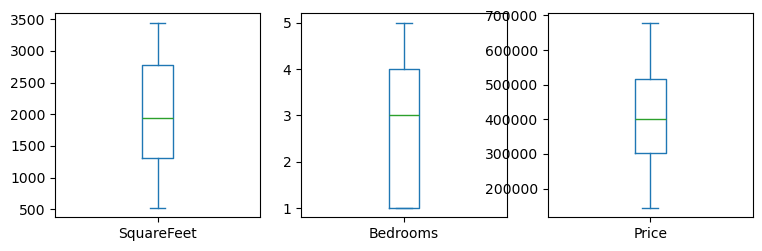

In [5]:
data.plot(kind='box', subplots=True, layout=(3,3),figsize=(9,9))

In [6]:
data.corr()

,SquareFeet,Bedrooms,Price
SquareFeet,1.000000,-0.029396,0.962524
Bedrooms,-0.029396,1.000000,0.188483
Price,0.962524,0.188483,1.000000


In [7]:
#the data is clear
data.columns


Index(['SquareFeet', 'Bedrooms', 'Price'], dtype='object')

C:\Users\djstu\AppData\Local\Temp\ipykernel_26688\759148748.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Price'])


<Axes: xlabel='Price', ylabel='Density'>

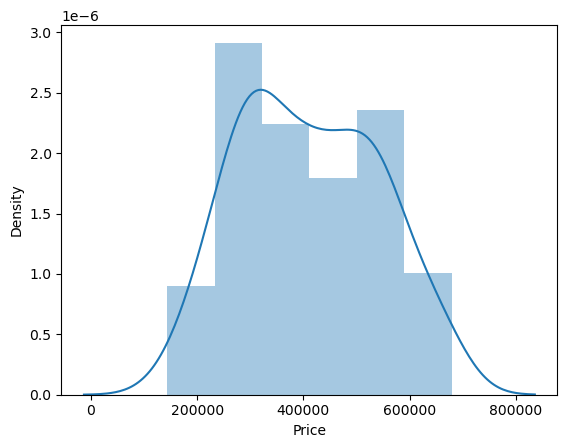

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data['Price'])

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
data.columns

Index(['SquareFeet', 'Bedrooms', 'Price'], dtype='object')

In [5]:
X=data[['SquareFeet','Bedrooms']]
Y=data['Price']

# data is not very normal
# --- IGNORE ---


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
#IAM password: xtW2L^5[
#user:jiny
#link: https://590396427679.signin.aws.amazon.com/console

In [11]:
# create an IAM user(administrator access)
# create a key for the user
# install awscli
# aws configure in commnand prompt


In [8]:
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\djstu\AppData\Local\sagemaker\sagemaker\config.yaml


In [9]:

# Correct way: put region inside quotes
region = "ap-south-1"
bucket = "sagemakervs"

# Create boto3 client with region
sm_boto3 = boto3.client("sagemaker", region_name=region)

# Create SageMaker session
session = sagemaker.Session(boto_session=boto3.session.Session(region_name=region))

print("Region:", region)
print("bucket:", bucket)


Region: ap-south-1
bucket: sagemakervs


In [10]:
print(X_train.shape, Y_train.shape)

(80, 2) (80,)


In [13]:
train_data=pd.concat([X_train, Y_train],axis=1)
Test_data=pd.concat([X_test, Y_test],axis=1)

In [14]:
train_data.head()

,SquareFeet,Bedrooms,Price
55,3445,4,639083
88,1291,3,301425
26,1247,1,266689
42,1146,3,284074
69,2000,5,467443


In [17]:
train_data.to_csv('train_data', index=False)
Test_data.to_csv('test_data', index=False)

In [18]:
session

#sent the data to S3 bucket

In [20]:
sk_prefix="sagemaker/linearregression/sagemakervs"
train_path=session.upload_data(path="train_data", bucket=bucket, key_prefix=sk_prefix)
sk_prefix="sagemaker/linearregression/sagemakervs"
test_path=session.upload_data(path="test_data", bucket=bucket, key_prefix=sk_prefix)
print(train_path)
print(test_path)

s3://sagemakervs/sagemaker/linearregression/sagemakervs/train_data
s3://sagemakervs/sagemaker/linearregression/sagemakervs/test_data


Find the sagemaker image_uris container for the linear regression

In [25]:
import sagemaker
from sagemaker import image_uris

region = "ap-south-1"

# Get the Docker image URI for Linear Learner
container = image_uris.retrieve(
    framework="linear-learner",
    region=region
)

print("Linear Learner image URI:", container)


Linear Learner image URI: 991648021394.dkr.ecr.ap-south-1.amazonaws.com/linear-learner:1


In [28]:
%%! writefile linear_regression.py
import argparse
import os
import json
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Default hyperparameters (for quick runs)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--learning-rate', type=float, default=0.01)
    parser.add_argument('--alpha', type=float, default=0.0001)

    # Data paths
    parser.add_argument('--train', type=str, default='train_data')
    parser.add_argument('--test', type=str, default='test_data')
    parser.add_argument('--model-dir', type=str, default='./model')

    args = parser.parse_args()
    print("Training with defaults:", args)

    # ---------- Load Data ----------
    train_data = pd.read_csv(args.train)
    test_data = pd.read_csv(args.test)

    X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
    X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

    # ---------- Hyperparameter Grid ----------
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'eta0': [0.001, 0.01, 0.1],          # learning rate
        'max_iter': [10, 50, 100]
    }

    # ---------- Define SGDRegressor ----------
    sgd = SGDRegressor(
        learning_rate='constant',
        random_state=42
    )

    # ---------- Grid Search ----------
    grid = GridSearchCV(
        estimator=sgd,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1
    )

    grid.fit(X_train, y_train)

    # ---------- Best Hyperparameters ----------
    print("Best Hyperparameters:", grid.best_params_)
    best_model = grid.best_estimator_

    # ---------- Evaluate ----------
    preds = best_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"Test MSE: {mse:.4f}")

    # ---------- Save Model ----------
    os.makedirs(args.model_dir, exist_ok=True)
    model_path = os.path.join(args.model_dir, "best_model.joblib")
    joblib.dump(best_model, model_path)
    print(f"Best model saved at {model_path}")


["'import' is not recognized as an internal or external command,",
 'operable program or batch file.']